**1. Use ID3 Algorithm to build a decision tree for a data set of your
choice with the two classes. Compute the depth of the tree. Us-
ing that Decision tree, compute the `class' of a given input. For
computing the `class' of a given input, you are not supposed to
use any library function.**

In [96]:
import math

class Node:
    def __init__(self, name):
        self.name = name
        self.label = None
        self.decisionAttr = None
        self.decisionGain = None
        self.decisionValue = None
        self.branches = []

    def printTree(self):
        self.printTreeRecurse(0)

    def printTreeRecurse(self, level):
        print ('\t' * level + self.name),
        if self.decisionAttr and self.decisionGain:
            print ('split by ' + str(self.decisionAttr) + ' for a gain of ' + str(self.decisionGain)),
        if self.label:
            print (' ' + self.label),
        #print ('\n'),
        level += 1
        for branch in self.branches:
            branch.printTreeRecurse(level)

    def predictOutcome(self, cases, a):
        predictions = []
        for c in cases:
            outcome = self.predictOutcomeRecurse(c, attributes)
            predictions.append(outcome)
        return predictions

    def predictOutcomeRecurse(self, case, a):
        if self.name == '':

            # Leaf nodes
            if self.label == '+':
                return 'Yes'
            elif self.label == '-':
                return 'No'

        index = a.index(self.decisionAttr)

        if self.decisionValue == case[index]:
            return self.branches[0].predictOutcomeRecurse(case, a)

        if self.decisionGain:
            # Traverse to the branch where branch.decisionValue is in the case
            for b in self.branches:
                if b.decisionValue == case[index]:
                    return b.predictOutcomeRecurse(case, a)


# Returns the root node of the constructed decision tree
def decisionTree(examples, targetAttribute, attributes):
    root = Node('')

    # Examples are all positive
    # The last attribute in the example is

    if all(isPositive(example[-1]) for example in examples):
        root.label = '+'
        return root

    # Examples are all negative
    elif all(not isPositive(example[-1]) for example in examples):
        root.label = '-'
        return root

    # Attributes is empty
    elif not attributes:
        root.label = commonLabel(examples)
        return root
    else:
        result = highestGain(attributes, examples)
        attr = result[0]
        gain = result[1]
        attrIndex = result[2]

        root.decisionAttr = attr
        root.decisionGain = gain

        possibleValues = uniqueValues(attrIndex, examples)

        for value in possibleValues:
            newBranch = Node(attr + ' = ' + value)
            newBranch.decisionAttr = attr
            newBranch.decisionValue = value
            root.branches.append(newBranch)
            branchExamples = sorted(row for row in examples if row[attrIndex] == value)

            if not branchExamples:
                leaf = Node(getMostCommonValue(targetAttribute, examples, possibleValues))
                newBranch.branches.append(leaf)
            else:
                newExamples = []
                for example in branchExamples:
                    newExample = []
                    for i in range(len(example)):
                        if not i == attrIndex:
                            newExample.append(example[i])
                    newExamples.append(newExample)

                newBranch.branches.append(decisionTree(newExamples, targetAttribute, [a for a in attributes if not a == attr]))

    return root


# Determines whether a word is positive ('yes', 'true', etc.)
def isPositive(word):
    word = word.lower()
    return word == 'yes' or word == 'true' or word == 'y' or word == 't'


# Returns the most common label (+ or -) in the given list of nodes
def commonLabel(nodes):
    pCount = 0
    nCount = 0

    for node in nodes:
        if node.label == '+':
            pCount += 1
        elif node.label == '-':
            nCount += 1

    if pCount >= nCount:
        return '+'
    else:
        return '-'


# Returns the attribute with the highest information gain, as well as the info gain value
def highestGain(attributes, examples):
    totalRows = len(examples)
    # Divide examples into positive and negative
    posExamples = sorted(row for row in examples if isPositive(row[-1]))
    negExamples = sorted(row for row in examples if not isPositive(row[-1]))

    # Get the expected info needed for the entire data set
    allExpectedInfo = computeExpectedInfo(len(posExamples), len(negExamples))

    valuesGain = []

    # Compute the entropy & gain of each attribute
    for i, attr in enumerate(attributes):

        # Don't check the target attribute
        if attributes[-1] == attributes[i]:
            break

        values = uniqueValues(i, examples)

        # Lists for the expected info & probability of each value
        valuesExpectedInfo = []
        valuesProbability = []

        # Compute the expected info needed for each value
        for value in values:
            # Count how many positive & negative examples there are for the value
            posExamplesOfValue = sorted(row for row in posExamples if row[i]==value)
            negExamplesOfValue = sorted(row for row in negExamples if row[i]==value)
            numPos = len(posExamplesOfValue)
            numNeg = len(negExamplesOfValue)
            # Compute the expected info & probability of the value & add them to the lists
            valueExpectedInfo = computeExpectedInfo(numPos, numNeg)
            valueProbability = float(numPos + numNeg) / float(totalRows)
            valuesExpectedInfo.append(valueExpectedInfo)
            valuesProbability.append(valueProbability)

        # Compute entropy & gain of value and add gain to the list
        valueEntropy = computeEntropy(valuesExpectedInfo, valuesProbability)
        valueGain = allExpectedInfo - valueEntropy
        valuesGain.append(valueGain)

    # The index of the attribute with the max gain
    index = valuesGain.index(max(valuesGain))

    return [attributes[index], valuesGain[index], index]


# Returns the expected info needed
# count1 is usually the number of positive examples
# count2 is usually num of negative examples
def computeExpectedInfo(count1, count2):
    count1 = float(count1)
    count2 = float(count2)
    total = count1 + count2
    prob1 = count1/total
    prob2 = count2/total

    # Can't call log(0)
    if prob1 > 0.0 and prob2 > 0.0:
        return -prob1 * math.log(prob1, 2.0) - prob2 * math.log(prob2, 2.0)
    elif prob1 > 0.0:
        return -prob1 * math.log(prob1, 2.0)
    elif prob2 > 0.0:
        return -prob2 * math.log(prob2, 2.0)
    else:
        print ('There was an error computing expected info.')
        return 0


# Compute entropy where p is a list of probabilities for each value and e is a
# list of expected info for each value. p and e should be the same length.
def computeEntropy(p, e):
    entropy = 0.0
    for i in range(len(p)):
        entropy += p[i] * e[i]
    return entropy


# Returns a list of the unique values of the given attribute (given by index) in the given examples
def uniqueValues(attrIndex, examples):
    values = []
    for e in examples:
        if e[attrIndex] not in values:
            values.append(e[attrIndex])
    return values


# Returns the most common value of the attribute in the examples
# Values param is the possible value for that attribute
def getMostCommonValue(attr, examples, values):
    valueCounts = []

    for value in values:
        valueCount = 0
        for example in examples:
            if example[attr] == value:
                valueCount += 1
        valueCounts.append(valueCount)

    maxIndex = valueCounts.index(max(valueCounts))
    return values[maxIndex]


# Returns the decision tree from a file containing training data
# where the first line contains the attributes separated by commas
# and each other line contains a data example
def constructTree(filepath):
    f = open(filepath, 'r')
    attrLine = f.readline()
    attributes = [a.strip() for a in attrLine.split(',')]
    examples = []
    for line in f:
        example = [item.strip() for item in line.split(',')]
        examples.append(example)

    # The last attribute is always the target attribute
    return decisionTree(examples, attributes[-1], attributes)


# Returns a list of test cases for the decision tree (examples that don't have
def testCases(filepath):
    f = open(filepath, 'r')
    cases = []
    for line in f:
        case = [item.strip() for item in line.split(',')]
        cases.append(case)

    return cases


def getAttributes(filepath):
    f = open(filepath, 'r')
    attrLine = f.readline()
    return [a.strip() for a in attrLine.split(',')]

In [97]:
trainingPath = input('Please enter the path to a file containing training data:\n')
tree = constructTree(trainingPath)
tree.printTree()

attributes = getAttributes(trainingPath)
attributes.pop(-1)

testingPath =   input('Please enter the path to a file containing cases to be tested:\n')
testCases = testCases(testingPath)
outcomes = tree.predictOutcome(testCases, attributes)
print (outcomes)

Please enter the path to a file containing training data:
train.txt

split by Outlook for a gain of 0.2467498197744391
	Outlook = Sunny
		
split by Humidity for a gain of 0.9709505944546686
			Humidity = Normal
				
 +
			Humidity = High
				
 -
	Outlook = Overcast
		
 +
	Outlook = Rain
		
split by Wind for a gain of 0.9709505944546686
			Wind = Strong
				
 -
			Wind = Weak
				
 +
Please enter the path to a file containing cases to be tested:
test.txt
['No']


**2. Build a Decision tree for a data set where all the input attributes
are continuous and the output attribute is categorical.**

In [98]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [99]:
iris_df = pd.read_csv("Iris.csv")
iris_df

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa
...,...,...,...,...,...,...
145,146,6.7,3.0,5.2,2.3,Iris-virginica
146,147,6.3,2.5,5.0,1.9,Iris-virginica
147,148,6.5,3.0,5.2,2.0,Iris-virginica
148,149,6.2,3.4,5.4,2.3,Iris-virginica


In [100]:
iris_df.isnull().sum()

Id               0
SepalLengthCm    0
SepalWidthCm     0
PetalLengthCm    0
PetalWidthCm     0
Species          0
dtype: int64

In [101]:
# Label Encoder is used for mapping categorical data into 1, 2, 3, 4, 5, 6..
from sklearn.preprocessing import LabelEncoder
le_encoder = LabelEncoder()
le_encoder.fit(iris_df['Species'])
iris_df['Species'] = le_encoder.transform(iris_df['Species'])

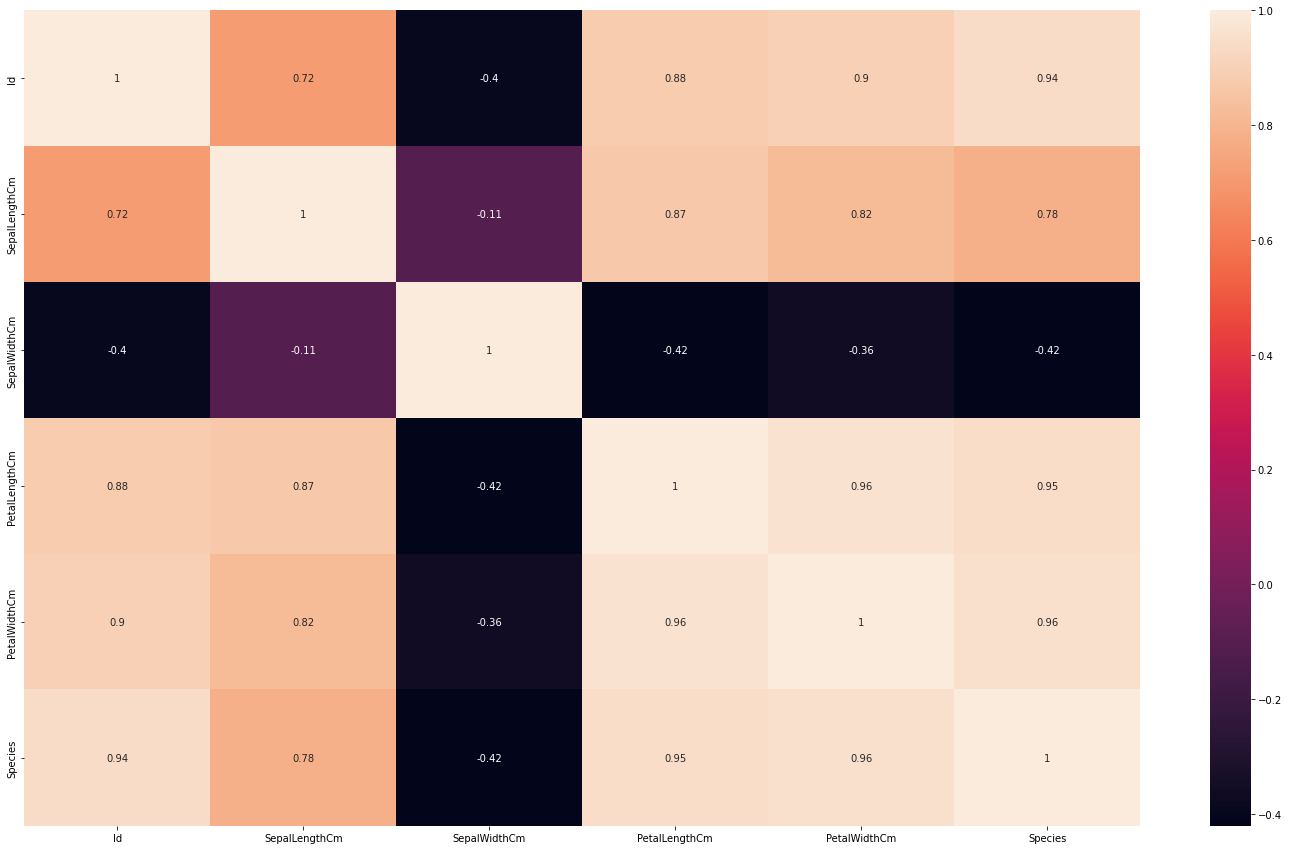

In [102]:
plt.figure(figsize=(25,15))
sns.heatmap(iris_df.corr('pearson'), annot = True)

Removing 'PetalLengthCm' and 'Id'

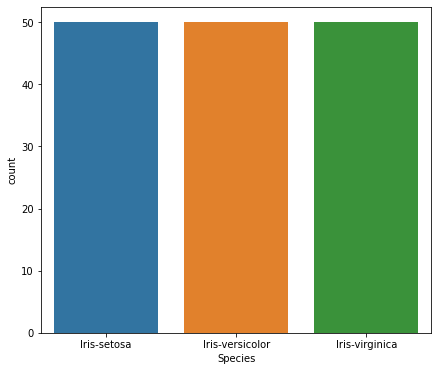

In [103]:
iris_df2 = pd.read_csv("Iris.csv")
plt.figure(figsize=(7,6))
sns.countplot('Species', data = iris_df2)

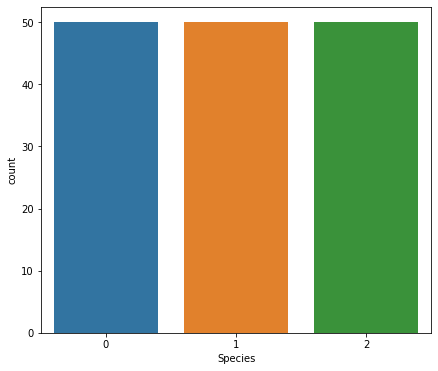

In [104]:
plt.figure(figsize=(7,6))
sns.countplot('Species', data = iris_df)

In [105]:
X = iris_df.drop(['PetalLengthCm','Id'], axis = 1)
Y = iris_df['Species']

**TRAIN-TEST DATA SPLIT**

In [106]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y , test_size = 0.2, random_state = 3)

In [107]:
from sklearn.tree import DecisionTreeClassifier
# maximum depth of decision trees is 9
clf_tree = DecisionTreeClassifier(criterion = "entropy", random_state = 0, max_depth = 9)

In [108]:
clf_tree.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [109]:
Y_Pred = clf_tree.predict(X_test)

In [110]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
report = classification_report(Y_Pred, Y_test)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00        10

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30



In [111]:
clf_tree.score(X_test, Y_test) 

1.0

In [112]:
clf_tree.score(X_train, Y_train) 

1.0

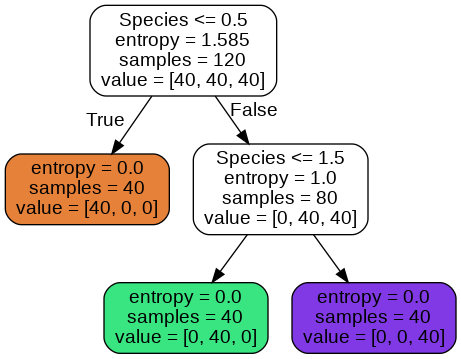

In [113]:
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_tree, out_file= dot_data, feature_names=list(X.columns), filled = True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png()) 

**5. Consider a data set with a minimum of four classes. Use sklearn
decision tree classi er with `One Vs One' and conduct the exper-
iment E1. Train the sklearn classi er with `one vs rest' strategy
and conduct the experiment E2. Generate the class cation re-
port for each of the experiment E1 and E2 and conclude which
is strategy works better for the dataset chosen by you.**

In [114]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.multiclass import OneVsOneClassifier, OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [115]:
data = pd.read_csv("vehicle.csv", header='infer')
data.head()

,compactness,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,max.length_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,max.length_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2,hollows_ratio,class
0,95,48.0,83.0,178.0,72.0,10,162.0,42.0,20.0,159,176.0,379.0,184.0,70.0,6.0,16.0,187.0,197,van
1,91,41.0,84.0,141.0,57.0,9,149.0,45.0,19.0,143,170.0,330.0,158.0,72.0,9.0,14.0,189.0,199,van
2,104,50.0,106.0,209.0,66.0,10,207.0,32.0,23.0,158,223.0,635.0,220.0,73.0,14.0,9.0,188.0,196,car
3,93,41.0,82.0,159.0,63.0,9,144.0,46.0,19.0,143,160.0,309.0,127.0,63.0,6.0,10.0,199.0,207,van
4,85,44.0,70.0,205.0,103.0,52,149.0,45.0,19.0,144,241.0,325.0,188.0,127.0,9.0,11.0,180.0,183,bus


In [116]:
data['class'].value_counts()

car    429
bus    218
van    199
Name: class, dtype: int64

In [117]:
data.isnull().sum()

compactness                    0
circularity                    5
distance_circularity           4
radius_ratio                   6
pr.axis_aspect_ratio           2
max.length_aspect_ratio        0
scatter_ratio                  1
elongatedness                  1
pr.axis_rectangularity         3
max.length_rectangularity      0
scaled_variance                3
scaled_variance.1              2
scaled_radius_of_gyration      2
scaled_radius_of_gyration.1    4
skewness_about                 6
skewness_about.1               1
skewness_about.2               1
hollows_ratio                  0
class                          0
dtype: int64

In [118]:
data.dropna(inplace=True)
data.isnull().sum()

compactness                    0
circularity                    0
distance_circularity           0
radius_ratio                   0
pr.axis_aspect_ratio           0
max.length_aspect_ratio        0
scatter_ratio                  0
elongatedness                  0
pr.axis_rectangularity         0
max.length_rectangularity      0
scaled_variance                0
scaled_variance.1              0
scaled_radius_of_gyration      0
scaled_radius_of_gyration.1    0
skewness_about                 0
skewness_about.1               0
skewness_about.2               0
hollows_ratio                  0
class                          0
dtype: int64

In [119]:
data.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
compactness,813.0,93.656827,8.233751,73.0,87.0,93.0,100.0,119.0
circularity,813.0,44.803198,6.146659,33.0,40.0,44.0,49.0,59.0
distance_circularity,813.0,82.043050,15.783070,40.0,70.0,79.0,98.0,112.0
radius_ratio,813.0,169.098401,33.615402,104.0,141.0,167.0,195.0,333.0
pr.axis_aspect_ratio,813.0,61.774908,7.973000,47.0,57.0,61.0,65.0,138.0
max.length_aspect_ratio,813.0,8.599016,4.677174,2.0,7.0,8.0,10.0,55.0
scatter_ratio,813.0,168.563346,33.082186,112.0,146.0,157.0,198.0,265.0
elongatedness,813.0,40.988930,7.803380,26.0,33.0,43.0,46.0,61.0
pr.axis_rectangularity,813.0,20.558426,2.573184,17.0,19.0,20.0,23.0,29.0
max.length_rectangularity,813.0,147.891759,14.504648,118.0,137.0,146.0,159.0,188.0


In [120]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 813 entries, 0 to 845
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   compactness                  813 non-null    int64  
 1   circularity                  813 non-null    float64
 2   distance_circularity         813 non-null    float64
 3   radius_ratio                 813 non-null    float64
 4   pr.axis_aspect_ratio         813 non-null    float64
 5   max.length_aspect_ratio      813 non-null    int64  
 6   scatter_ratio                813 non-null    float64
 7   elongatedness                813 non-null    float64
 8   pr.axis_rectangularity       813 non-null    float64
 9   max.length_rectangularity    813 non-null    int64  
 10  scaled_variance              813 non-null    float64
 11  scaled_variance.1            813 non-null    float64
 12  scaled_radius_of_gyration    813 non-null    float64
 13  scaled_radius_of_gyr

In [121]:
#Feature & Target Selection
features = data.select_dtypes('float','int').columns
target = ['class']
# Feature& Target Dataset
X = data[features]
y = data[target]

In [122]:
X.head()

,circularity,distance_circularity,radius_ratio,pr.axis_aspect_ratio,scatter_ratio,elongatedness,pr.axis_rectangularity,scaled_variance,scaled_variance.1,scaled_radius_of_gyration,scaled_radius_of_gyration.1,skewness_about,skewness_about.1,skewness_about.2
0,48.0,83.0,178.0,72.0,162.0,42.0,20.0,176.0,379.0,184.0,70.0,6.0,16.0,187.0
1,41.0,84.0,141.0,57.0,149.0,45.0,19.0,170.0,330.0,158.0,72.0,9.0,14.0,189.0
2,50.0,106.0,209.0,66.0,207.0,32.0,23.0,223.0,635.0,220.0,73.0,14.0,9.0,188.0
3,41.0,82.0,159.0,63.0,144.0,46.0,19.0,160.0,309.0,127.0,63.0,6.0,10.0,199.0
4,44.0,70.0,205.0,103.0,149.0,45.0,19.0,241.0,325.0,188.0,127.0,9.0,11.0,180.0


In [123]:
y.head()

,class
0,van
1,van
2,car
3,van
4,bus


Data Split & Feature Scaling

In [124]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=True)

**ONE vs ONE:**

In [125]:
model = LogisticRegression()
ovo = OneVsOneClassifier(model)
#fit model to training data
ovo.fit(X_train, y_train.values.ravel())
#Predications
ovo_pred = ovo.predict(X_test)
print(metrics.classification_report(ovo_pred, y_test))

              precision    recall  f1-score   support

         bus       0.91      0.91      0.91        33
         car       0.98      0.90      0.94        93
         van       0.75      0.89      0.81        37

    accuracy                           0.90       163
   macro avg       0.88      0.90      0.89       163
weighted avg       0.91      0.90      0.90       163



**ONE vs REST:**

In [126]:
ovr = OneVsRestClassifier(model)
ovr.fit(X_train, y_train.values.ravel())
ovr_pred = ovr.predict(X_test)
print(metrics.classification_report(ovr_pred, y_test))

              precision    recall  f1-score   support

         bus       0.88      0.91      0.89        32
         car       0.99      0.92      0.96        92
         van       0.84      0.95      0.89        39

    accuracy                           0.93       163
   macro avg       0.90      0.93      0.91       163
weighted avg       0.93      0.93      0.93       163



***As we can see, the 'ONE vs REST' Model is better for the 'vehicle' dataset I have chosen, as the precision values & f1-score values of each class(except 'bus'), overall accuracy (Both macro and weighted average) values are HIGHER for 'ONE vs REST' than 'ONE vs ONE'.***

----------------------------

**7) Consider a 2-class dataset. Design a decision tree for the cho-
sen data set such that classi er has zero error with the training
dataset.**

In [127]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [128]:
wine_df = pd.read_csv('winequalityN.csv')
wine_df

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.270,0.36,20.7,0.045,45.0,170.0,1.00100,3.00,0.45,8.8,6
1,white,6.3,0.300,0.34,1.6,0.049,14.0,132.0,0.99400,3.30,0.49,9.5,6
2,white,8.1,0.280,0.40,6.9,0.050,30.0,97.0,0.99510,3.26,0.44,10.1,6
3,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
4,white,7.2,0.230,0.32,8.5,0.058,47.0,186.0,0.99560,3.19,0.40,9.9,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6492,red,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
6493,red,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,NaN,11.2,6
6494,red,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
6495,red,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [129]:
wine_df.isnull().sum()

type                     0
fixed acidity           10
volatile acidity         8
citric acid              3
residual sugar           2
chlorides                2
free sulfur dioxide      0
total sulfur dioxide     0
density                  0
pH                       9
sulphates                4
alcohol                  0
quality                  0
dtype: int64

In [130]:
wine_df.dropna(inplace=True)
wine_df.isnull().sum()

type                    0
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

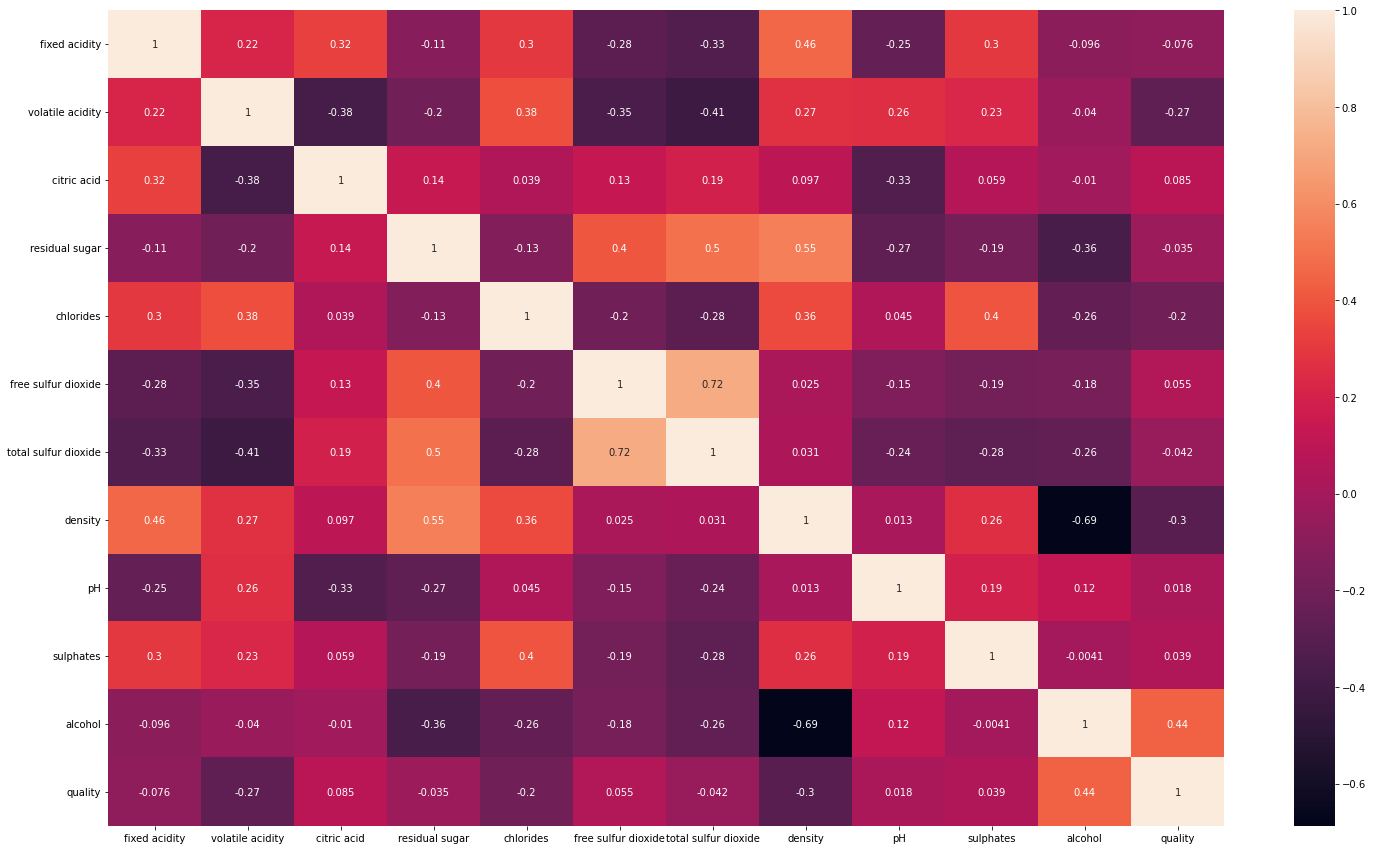

In [131]:
plt.figure(figsize=(25,15))
sns.heatmap(wine_df.corr('pearson'), annot = True)

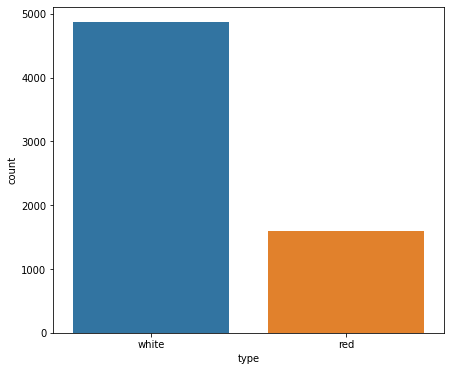

In [132]:
plt.figure(figsize=(7,6))
sns.countplot('type', data = wine_df)

In [133]:
wine_df['type'].value_counts()

white    4870
red      1593
Name: type, dtype: int64

***Mapping 'White' and 'red' wine as 1 and 0 respectively:***

In [134]:
from sklearn.preprocessing import LabelEncoder
le_encoder = LabelEncoder()
le_encoder.fit(wine_df['type'])
wine_df['type'] = le_encoder.transform(wine_df['type'])
wine_df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,1,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,1,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,1,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [135]:
wine_df['type'].value_counts()

1    4870
0    1593
Name: type, dtype: int64

**Data Augmentation Bootstrap Method:**

In [136]:
from sklearn.utils import resample
df_0 = wine_df[wine_df['type'] == False]
df_1 = wine_df[wine_df['type'] == True]

In [137]:
df_1.shape

(4870, 13)

In [138]:
# Apply Resample
df_1_upsample = resample(df_1, n_samples = 288, replace = True, random_state = 123)

In [139]:
df_1_upsample.shape

(288, 13)

In [140]:
d = df_1_upsample.drop_duplicates()
d.shape

(277, 13)

In [141]:
wine_df1 = pd.concat([df_0, df_1_upsample])
wine_df1.shape

(1881, 13)

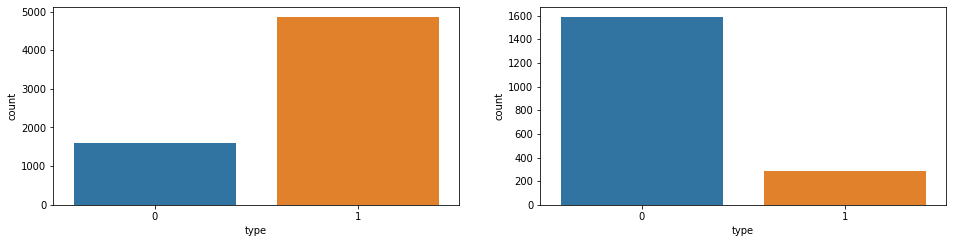

In [142]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.countplot('type', data = wine_df)
plt.subplot(2,2,2)
sns.countplot('type', data = wine_df1)
plt.show()

**Synthetic Minority Oversampling Technique (SMOTE):**

In [143]:
X = wine_df1.drop(['type'],axis = 1)
Y = wine_df1['type']

In [144]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y , test_size = 0.2, random_state = 3)

In [145]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, Y_train = sm.fit_resample(X_train, Y_train)

In [146]:
X_Full = np.hstack((X_train,Y_train.reshape(-1,1)))

Decision Tree:

In [147]:
from sklearn.tree import DecisionTreeClassifier
# maximum depth of decision trees is 9
clf_tree = DecisionTreeClassifier(criterion = "entropy", random_state = 0,max_depth = 9)
clf_tree.fit(X_train, Y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=9, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

In [148]:
clf_tree.score(X_test, Y_test)

0.9814323607427056

In [149]:
clf_tree.score(X_train, Y_train)

1.0

***As we can see here, decision tree for this red/white wine data-set such that classifier has zero error with the training dataset.***

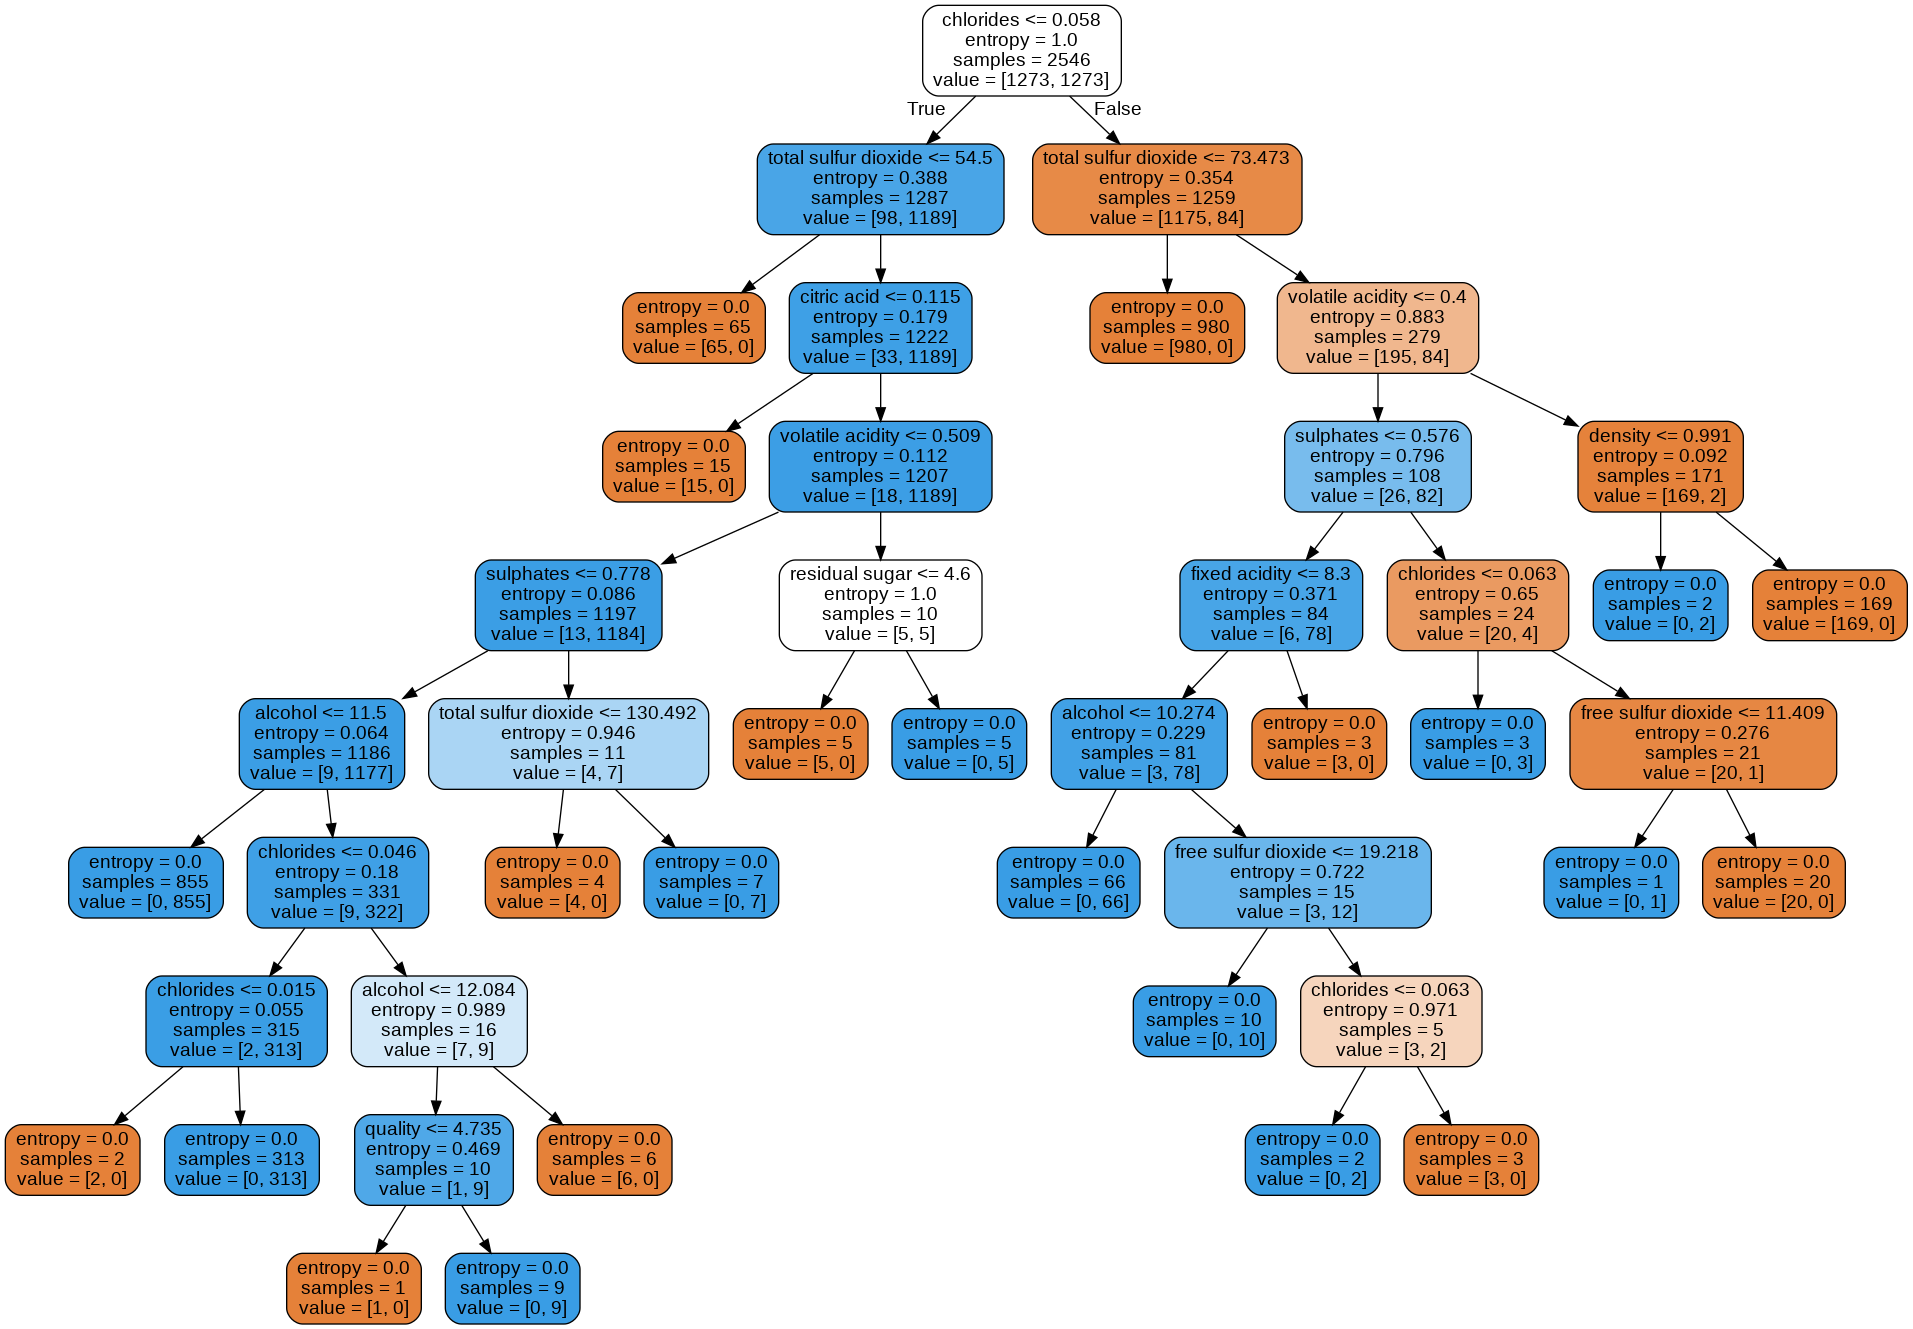

In [150]:
from sklearn.externals.six import StringIO
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(clf_tree, out_file= dot_data, feature_names=list(X.columns),filled = True, rounded=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

In [151]:
Y_Pred = clf_tree.predict(X_test)

In [152]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
report = classification_report(Y_Pred, Y_test)
print(report)

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       323
           1       0.91      0.96      0.94        54

    accuracy                           0.98       377
   macro avg       0.95      0.97      0.96       377
weighted avg       0.98      0.98      0.98       377



*** 8. Consider a multi-class dataset. With this datatset, train a randomforest ensembler to classfiy the data. Generate the classification report on the peformance of the ensembler. Using the trained ensembler, predict the label of the validation dataset. ***

In [153]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [154]:
titanic_df = pd.read_csv("titanic.csv", sep = ',')
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [155]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [156]:
titanic_df.drop('Cabin', axis = 1, inplace=True)

In [157]:
titanic_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
PassengerId,891.0,446.000000,257.353842,1.00,223.5000,446.0000,668.5,891.0000
Survived,891.0,0.383838,0.486592,0.00,0.0000,0.0000,1.0,1.0000
Pclass,891.0,2.308642,0.836071,1.00,2.0000,3.0000,3.0,3.0000
Age,714.0,29.699118,14.526497,0.42,20.1250,28.0000,38.0,80.0000
SibSp,891.0,0.523008,1.102743,0.00,0.0000,0.0000,1.0,8.0000
Parch,891.0,0.381594,0.806057,0.00,0.0000,0.0000,0.0,6.0000
Fare,891.0,32.204208,49.693429,0.00,7.9104,14.4542,31.0,512.3292


In [158]:
median_class1 = titanic_df[titanic_df['Pclass'] == 1]['Age'].median()
median_class1

37.0

In [159]:
median_class2 = titanic_df[titanic_df['Pclass'] == 2]['Age'].median()
median_class2

29.0

In [160]:
median_class3 = titanic_df[titanic_df['Pclass'] == 3]['Age'].median()
median_class3

24.0

In [161]:
def imputer_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    if pd.isnull(Age):
        if Pclass == 1:
            return median_class1
        elif Pclass == 2:
            return median_class2
        else:
            return median_class3
    else:
        return Age

In [162]:
# .apply(function name) => modify or apply changes in DataFrames
titanic_df['Age'] = titanic_df[['Age','Pclass']].apply(imputer_age, axis = 1)

In [163]:
titanic_df.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [164]:
# dropna() - drops entire row having any single missing values with NaN
titanic_df.dropna(inplace=True)

In [165]:
titanic_df.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

In [166]:
from sklearn.preprocessing import LabelEncoder
le_encoder = LabelEncoder()

le_encoder.fit(titanic_df['Sex'].drop_duplicates())

titanic_df['Sex'] = le_encoder.transform(titanic_df['Sex'])
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",0,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,S


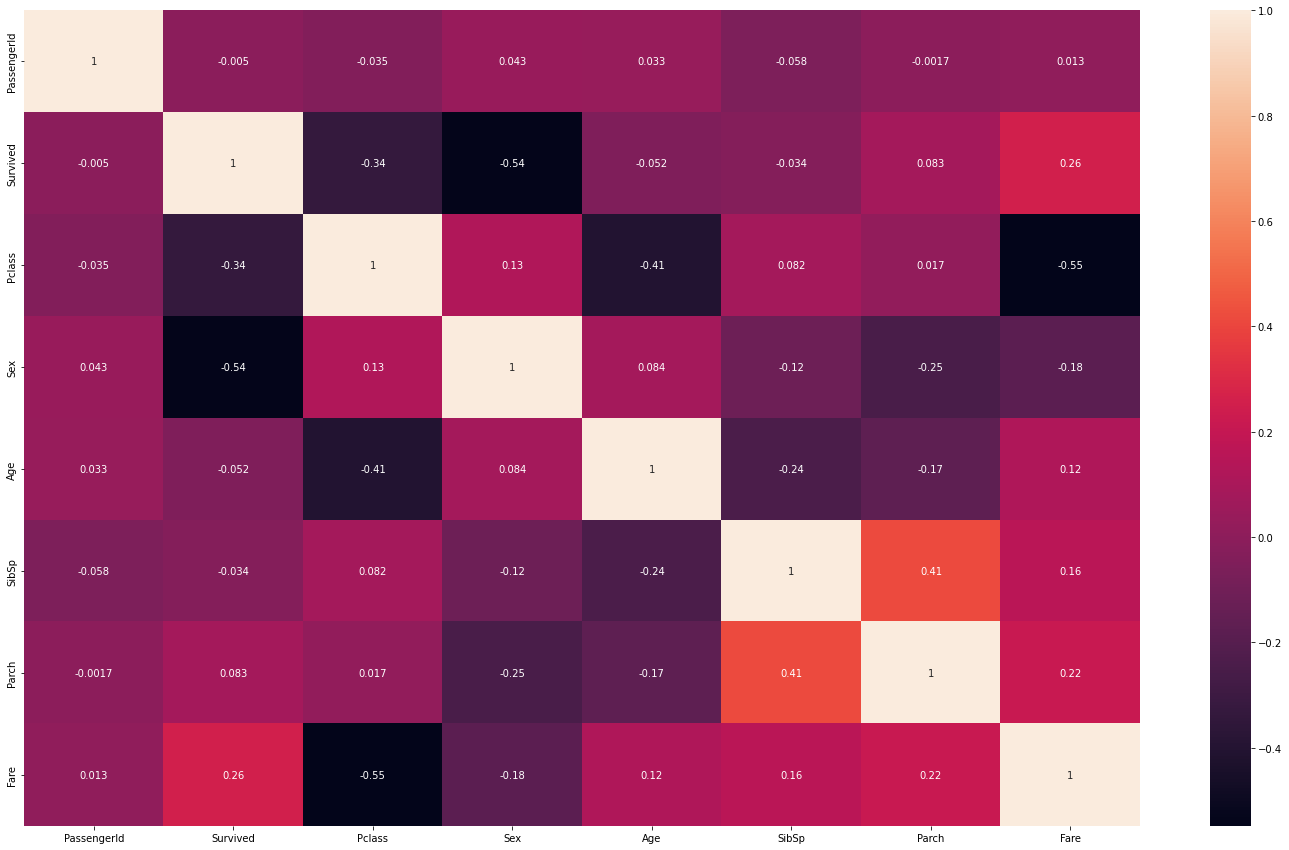

In [167]:
plt.figure(figsize=(25,15))
sns.heatmap(titanic_df.corr('pearson'), annot = True)

In [168]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    int64  
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(6), object(3)
memory usage: 83.3+ KB


In [169]:
# resample uses "bootstrapping" method to regenrate samples by randomly selecting data for each class
from sklearn.utils import resample
df_0 = titanic_df[titanic_df['Embarked'] == 'S']
df_1 = titanic_df[titanic_df['Embarked'] == 'C']
df_2 = titanic_df[titanic_df['Embarked'] == 'Q']

In [170]:
df_1_upsample = resample(df_1, n_samples = 644, replace = True, random_state = 123)

In [171]:
df_1_upsample.shape

(644, 11)

In [172]:
df_2_upsample = resample(df_2, n_samples = 644, replace = True, random_state = 123)

In [173]:
df_2_upsample.shape

(644, 11)

In [174]:
churn_df1 = pd.concat([df_0, df_1_upsample, df_2_upsample])

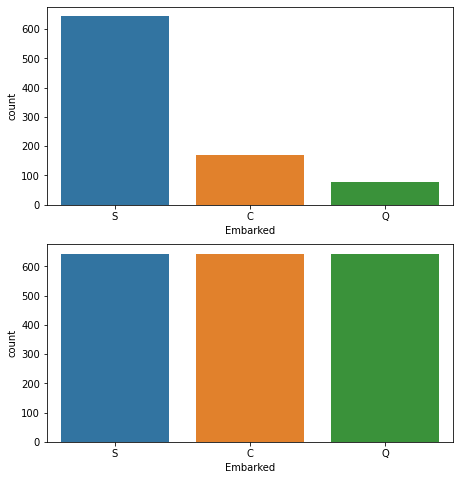

In [175]:
plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
#Without UpSampling
sns.countplot('Embarked', data = titanic_df)
plt.subplot(2,2,3)
#With UpSampling
sns.countplot('Embarked', data = churn_df1)
plt.show()

In [176]:
#Feature & Target Selection
features = churn_df1.select_dtypes('float').columns
target = ['Embarked']
# Feature& Target Dataset
X = churn_df1[features]
Y = churn_df1[target]

In [177]:
X.head()

,Age,Fare
0,22.0,7.2500
2,26.0,7.9250
3,35.0,53.1000
4,35.0,8.0500
6,54.0,51.8625


In [178]:
Y.head()

,Embarked
0,S
2,S
3,S
4,S
6,S


In [179]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0, shuffle=True)

In [180]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_train, Y_train = sm.fit_resample(X_train, Y_train)

In [181]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100,bootstrap=False)
rfc.fit(X_train, Y_train)

RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [182]:
X_train.shape

(1593, 2)

In [183]:
y_pred = rfc.predict(X_test)

In [184]:
from sklearn import metrics
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(Y_test, y_pred))

ACCURACY OF THE MODEL:  0.9483204134366925


In [185]:
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report
report = classification_report(y_pred, Y_test)
print(report)

              precision    recall  f1-score   support

           C       0.99      0.89      0.94       126
           Q       1.00      0.96      0.98       137
           S       0.87      0.99      0.92       124

    accuracy                           0.95       387
   macro avg       0.95      0.95      0.95       387
weighted avg       0.95      0.95      0.95       387

